# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_percolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 5, 5
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['conv_7b']
    PREPROCESSING = tf.keras.applications.inception_resnet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8221 - accuracy: 0.7286

947/947 [==============================] - 3863s 4s/step - loss: 0.8221 - accuracy: 0.7286 - val_loss: 0.8210 - val_accuracy: 0.7237
Epoch 2/200
947/947 [==============================] - ETA: 0s - loss: 0.7040 - accuracy: 0.7579

947/947 [==============================] - 3394s 4s/step - loss: 0.7040 - accuracy: 0.7579 - val_loss: 0.6887 - val_accuracy: 0.7578
Epoch 3/200
947/947 [==============================] - 3013s 3s/step - loss: 0.6541 - accuracy: 0.7721 - val_loss: 0.7162 - val_accuracy: 0.7361
Epoch 4/200
947/947 [==============================] - 3032s 3s/step - loss: 0.6217 - accuracy: 0.7845 - val_loss: 0.9491 - val_accuracy: 0.7424
Epoch 5/200
947/947 [==============================] - 3054s 3s/step - loss: 0.5906 - accuracy: 0.7919 - val_loss: 0.8966 - val_accuracy: 0.7243
Epoch 6/200
947/947 [==============================] - ETA: 0s - loss: 0.5632 - accuracy: 0.8019

947/947 [==============================] - 3292s 3s/step - loss: 0.5632 - accuracy: 0.8019 - val_loss: 0.6286 - val_accuracy: 0.7852
Epoch 7/200
947/947 [==============================] - ETA: 0s - loss: 0.5427 - accuracy: 0.8083

947/947 [==============================] - 3356s 4s/step - loss: 0.5427 - accuracy: 0.8083 - val_loss: 0.5940 - val_accuracy: 0.7884
Epoch 8/200
947/947 [==============================] - ETA: 0s - loss: 0.5230 - accuracy: 0.8129

947/947 [==============================] - 3268s 3s/step - loss: 0.5230 - accuracy: 0.8129 - val_loss: 0.5572 - val_accuracy: 0.8023
Epoch 9/200
947/947 [==============================] - 3031s 3s/step - loss: 0.4978 - accuracy: 0.8236 - val_loss: 0.6546 - val_accuracy: 0.7601
Epoch 10/200
947/947 [==============================] - 2996s 3s/step - loss: 0.4856 - accuracy: 0.8274 - val_loss: 0.5597 - val_accuracy: 0.8113
Epoch 11/200
947/947 [==============================] - ETA: 0s - loss: 0.4758 - accuracy: 0.8290

947/947 [==============================] - 3261s 3s/step - loss: 0.4758 - accuracy: 0.8290 - val_loss: 0.5485 - val_accuracy: 0.8019
Epoch 12/200
947/947 [==============================] - 2992s 3s/step - loss: 0.4720 - accuracy: 0.8339 - val_loss: 0.5953 - val_accuracy: 0.7895
Epoch 13/200
947/947 [==============================] - ETA: 0s - loss: 0.4723 - accuracy: 0.8324

947/947 [==============================] - 3279s 3s/step - loss: 0.4723 - accuracy: 0.8324 - val_loss: 0.5031 - val_accuracy: 0.8279
Epoch 14/200
947/947 [==============================] - ETA: 0s - loss: 0.4405 - accuracy: 0.8432

947/947 [==============================] - 3253s 3s/step - loss: 0.4405 - accuracy: 0.8432 - val_loss: 0.4946 - val_accuracy: 0.8295
Epoch 15/200
947/947 [==============================] - 3151s 3s/step - loss: 0.4229 - accuracy: 0.8469 - val_loss: 0.5121 - val_accuracy: 0.8212
Epoch 16/200
947/947 [==============================] - 3047s 3s/step - loss: 0.4097 - accuracy: 0.8520 - val_loss: 0.5827 - val_accuracy: 0.7986
Epoch 17/200
947/947 [==============================] - 3058s 3s/step - loss: 0.3979 - accuracy: 0.8558 - val_loss: 0.5055 - val_accuracy: 0.8172
Epoch 18/200
947/947 [==============================] - ETA: 0s - loss: 0.3791 - accuracy: 0.8619

947/947 [==============================] - 3357s 4s/step - loss: 0.3791 - accuracy: 0.8619 - val_loss: 0.4784 - val_accuracy: 0.8336
Epoch 19/200
947/947 [==============================] - 3023s 3s/step - loss: 0.3716 - accuracy: 0.8644 - val_loss: 0.4799 - val_accuracy: 0.8423
Epoch 20/200
947/947 [==============================] - 3034s 3s/step - loss: 0.3570 - accuracy: 0.8712 - val_loss: 0.4912 - val_accuracy: 0.8332
Epoch 21/200
947/947 [==============================] - 3027s 3s/step - loss: 0.3432 - accuracy: 0.8750 - val_loss: 0.5115 - val_accuracy: 0.8257
Epoch 22/200
947/947 [==============================] - 3148s 3s/step - loss: 0.3345 - accuracy: 0.8790 - val_loss: 0.5253 - val_accuracy: 0.8206
Epoch 23/200
947/947 [==============================] - 2998s 3s/step - loss: 0.3220 - accuracy: 0.8809 - val_loss: 0.4871 - val_accuracy: 0.8334
Epoch 24/200
947/947 [==============================] - 2986s 3s/step - loss: 0.3089 - accuracy: 0.8887 - val_loss: 0.5074 - val_accuracy

947/947 [==============================] - 3557s 4s/step - loss: 0.3040 - accuracy: 0.8905 - val_loss: 0.4500 - val_accuracy: 0.8488
Epoch 26/200
947/947 [==============================] - 3243s 3s/step - loss: 0.2849 - accuracy: 0.8951 - val_loss: 0.5135 - val_accuracy: 0.8284
Epoch 27/200
947/947 [==============================] - 3076s 3s/step - loss: 0.2733 - accuracy: 0.8995 - val_loss: 0.4572 - val_accuracy: 0.8478
Epoch 28/200
947/947 [==============================] - 3006s 3s/step - loss: 0.2670 - accuracy: 0.9027 - val_loss: 0.4744 - val_accuracy: 0.8386
Epoch 29/200
947/947 [==============================] - 3236s 3s/step - loss: 0.2536 - accuracy: 0.9066 - val_loss: 0.5195 - val_accuracy: 0.8369
Epoch 30/200
947/947 [==============================] - 3119s 3s/step - loss: 0.2479 - accuracy: 0.9091 - val_loss: 0.4754 - val_accuracy: 0.8498
Epoch 31/200
947/947 [==============================] - 3188s 3s/step - loss: 0.2400 - accuracy: 0.9115 - val_loss: 0.4832 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 308s 2s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9740406422524012,
 'basal cell carcinoma': 0.986912963575222,
 'dermatofibroma': 0.9893019364092757,
 'melanoma': 0.9424204758739813,
 'nevus': 0.9718812205109832,
 'pigmented benign keratosis': 0.988258051931163,
 'seborrheic keratosis': 0.9616269450597533,
 'solar lentigo': 0.9716411426088846,
 'squamous cell carcinoma': 0.9753592878592878,
 'vascular lesion': 0.9985663082437276}

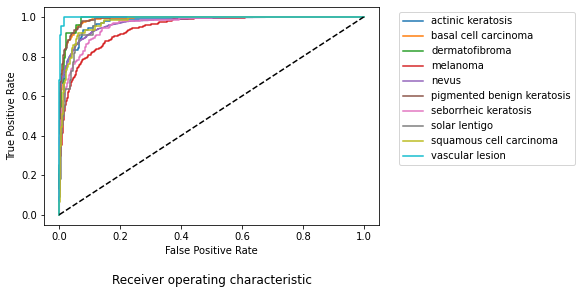

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

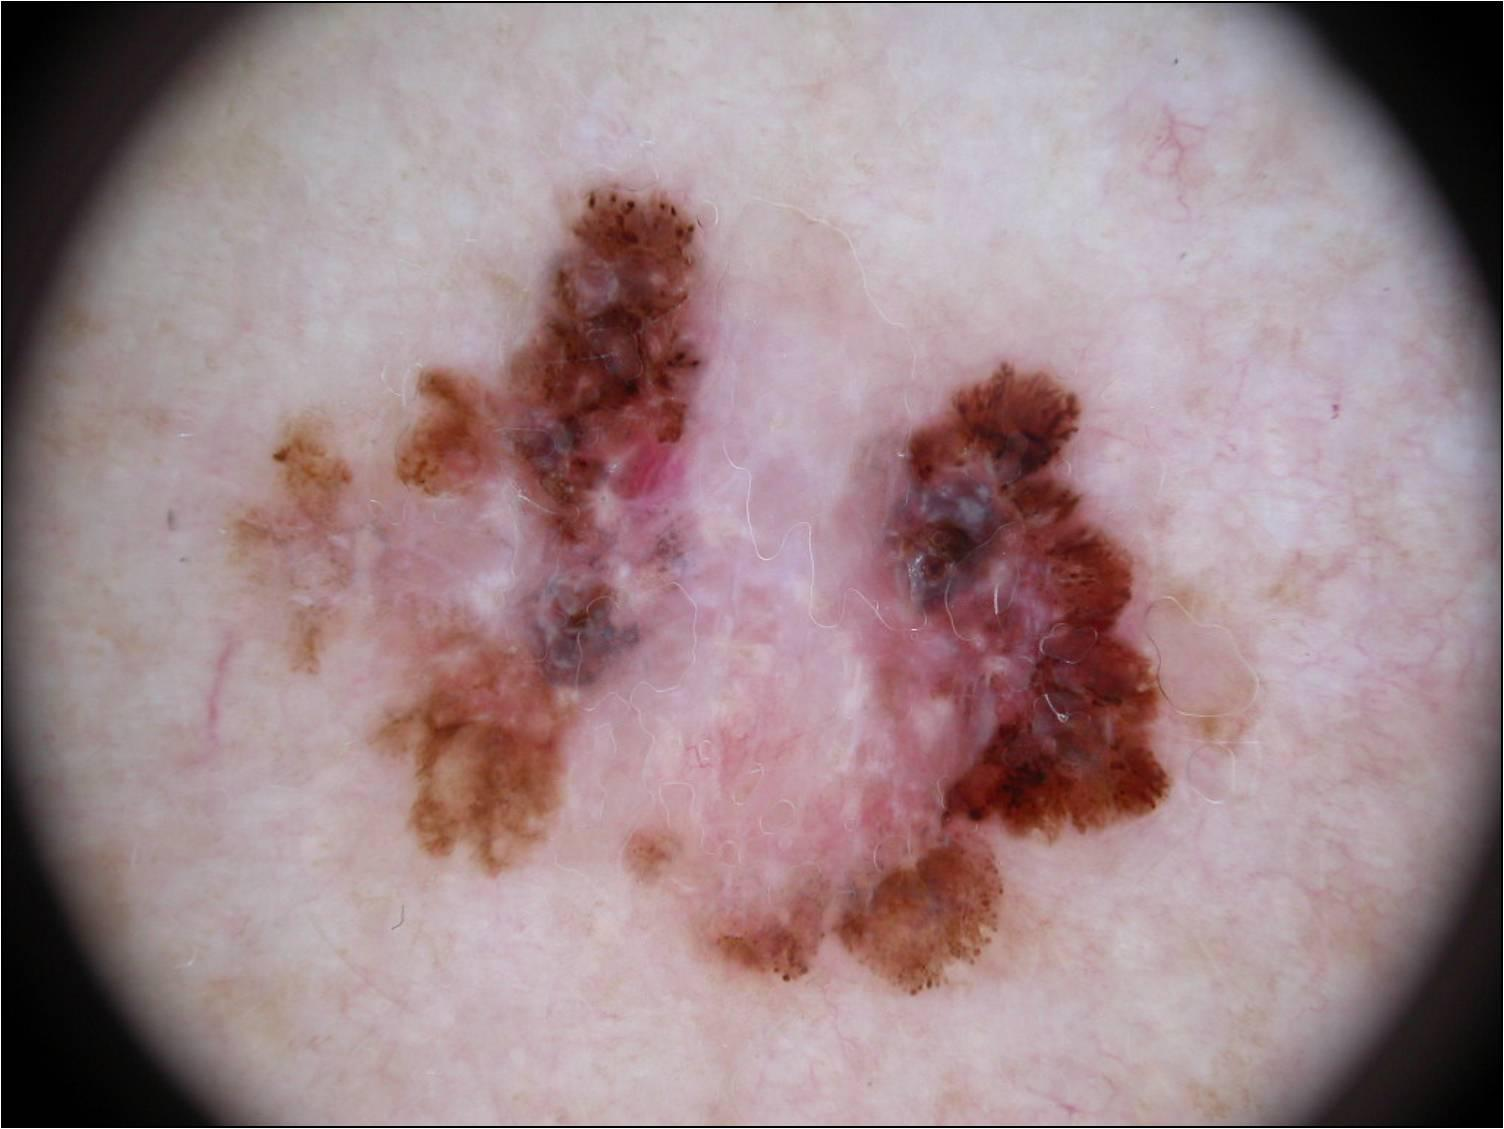

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, RETRAINABLE_LAYERS[-1])

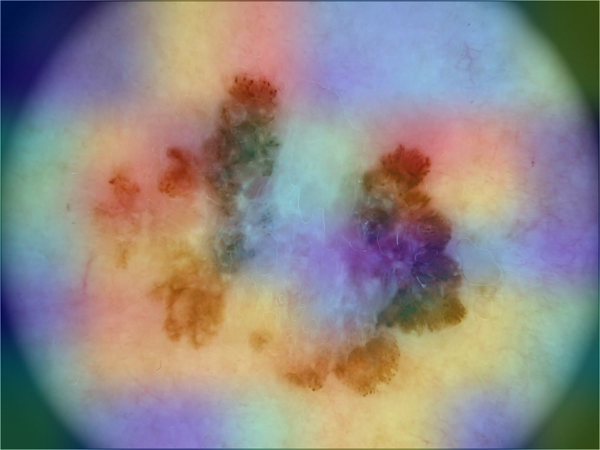

In [23]:
display_gradcam(melanoma_im_path, heatmap)